# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

You should produce a Jupyter notebook and a `.txt` file (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

Place your notebook and `.txt` files **only** in a directory called `iamlans` and submit this directory using the submit command on a DICE machine. The format is:

`submit iaml 3 iamlans`

You can check the status of your submissions with the `show_submissions` command.

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).


## Important Instructions

1. In the following questions you are asked to run experiments using Python (version 2.7) and the following packages:
    * Numpy
    * Pandas
    * Scikit-learn 0.17
    * Matplotlib
    * Seaborn

2. Before you start make sure you have set up a vitual environment (or conda environment if you are working on your own machine) and the required packages installed. Instructions on how to set-up the working enviornment and install the required packages can be found in `01_Lab_1_Introduction`.

3. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

4. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

5. **IMPORTANT:** Keep your answers brief and concise. Most questions can be answered with 2-3 lines of explanation (excluding coding questions), unless stated otherwise.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [141]:
from __future__ import division #,print_function
%matplotlib inline

# Your code goes here
import math
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler #LabelEncoder
from sklearn.svm import LinearSVC, SVC
#from sklearn.svm import LinearSVC, SVC
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.metrics import confusion_matrix, log_loss

In [2]:
seed = 0

## Description of the dataset
In this assignment our goal is to recognize objects from 19 dierent visual classes (e.g. person, dog, cat, car, ...) in realistic scenes. The dataset consists of several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

Here we will focus on a single classiffication task: you will be required to classify images as to whether or not they contain a person. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. That is, each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 diffeerent visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image). Our dataset with all images is thus a $N \times 500$ dimensional matrix where `N` is the number of images. The resulting representation is much more compact and can be used directly to perform classiffication.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) correspond to the normalized count vector. The last 19 attributes (`is_class`) indicate the presence of at least one object of a particular class in the image. In most of the experiments (unless explicitly noted otherwise) you will be asked to train classiffiers for classifying person vs. non-person images and only the `is_person` attribute and the 500 dimensional feature vector will be used. Do not use the additional class indicator attributes as features unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

*Important: Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 ==========
Load the datasets `train_images_partA.csv` and `valid_images_partA.csv` into two pandas DataFrame called `train_A` and `valid_A`. Display the number of data points and attributes in each of the two datasets.

In [3]:
def loadDataset(name):
    data_path = os.path.join(os.getcwd(), 'datasets', name + '.csv')
    return pd.read_csv(data_path, delimiter = ',')

In [4]:
# Your code goes here
trainA = loadDataset('train_images_partA')
validA = loadDataset('valid_images_partA')

In [5]:
print "number of data points for training data of partA"
print len(trainA)
print
print "number of data points for validation data of partA"
print len(validA)

number of data points for training data of partA
2093

number of data points for validation data of partA
1113


In [6]:
print "number of attributes for training data of partA"
print len(trainA.columns)
print
print "number of attributes for validation data of partA"
print len(validA.columns)

number of attributes for training data of partA
520

number of attributes for validation data of partA
520


### ========== Question 1.2 ==========
Display and inspect the first 10 instances in the training dataset.

In [7]:
# Your code goes here
trainA[:10]

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [8]:
validA[:10]

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_002199,0.001698,0.000000,0.003057,0.002378,0.001019,0.001698,0.000340,0.001019,0.001359,...,0,0,0,0,0,1,0,0,0,0
1,2008_002179,0.002038,0.000000,0.004076,0.001019,0.001019,0.001019,0.000679,0.001019,0.001019,...,0,0,0,0,1,1,0,0,0,0
2,2008_002495,0.001116,0.000000,0.005208,0.001860,0.001116,0.000000,0.001488,0.002232,0.001116,...,0,0,0,0,0,1,0,0,0,0
3,2008_007171,0.001698,0.000340,0.004076,0.000679,0.002038,0.001019,0.002038,0.001019,0.000340,...,0,0,0,0,0,1,0,0,0,0
4,2008_003793,0.003736,0.001019,0.000679,0.001019,0.003736,0.002038,0.002038,0.001359,0.002717,...,0,0,0,0,0,1,0,0,0,0
5,2008_007585,0.002378,0.000000,0.003057,0.002717,0.001698,0.001698,0.001359,0.002038,0.005095,...,0,0,0,0,0,1,0,0,0,0
6,2008_001255,0.003057,0.000000,0.009511,0.001359,0.001698,0.000340,0.002378,0.005095,0.002038,...,0,0,0,0,0,1,0,0,0,0
7,2008_000984,0.000744,0.000372,0.001860,0.001860,0.002232,0.002232,0.002604,0.000372,0.001860,...,0,0,0,0,0,1,0,0,0,0
8,2008_008474,0.003057,0.000000,0.002717,0.005095,0.001698,0.002378,0.001019,0.000000,0.001359,...,0,1,0,0,0,1,0,0,0,0
9,2008_000204,0.002437,0.000000,0.007310,0.000975,0.000000,0.002924,0.000000,0.000000,0.001949,...,0,0,0,0,0,1,0,0,0,0


### ========== Question 1.3 ==========
In this part we want to select the appopriate attributes (i.e. input features) for training our classifiers. These should be the attributes `dim1, dim2, ..., dim500`. Create a list which has as elements the **names** of the attributes of interest. 

In [9]:
# Your code goes here
noOfVisualWords = 500

In [10]:
cols = trainA.columns

In [11]:
inputFeatures = cols[["dim" in colName for colName in cols]]
inputFeatures

Index([u'dim1', u'dim2', u'dim3', u'dim4', u'dim5', u'dim6', u'dim7', u'dim8',
       u'dim9', u'dim10',
       ...
       u'dim491', u'dim492', u'dim493', u'dim494', u'dim495', u'dim496',
       u'dim497', u'dim498', u'dim499', u'dim500'],
      dtype='object', length=500)

In [12]:
assert len(inputFeatures) == noOfVisualWords, "we should be able to get the right number of features"

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` and store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets (also make sure you do not include this attribute in your training features). Display the dimensionalities (i.e shapes) of the 4 arrays and make sure your input data are 500-dimensional.

In [13]:
targetName = 'is_person'

In [14]:
# Your code goes here
Xtr = trainA[inputFeatures]
Xval = validA[inputFeatures]
yTr = trainA[targetName]
yVal = validA[targetName]

In [15]:
print "dimesionality of training input data"
print Xtr.shape
print
print "dimesionality of validation input data"
print Xval.shape
print
print "dimesionality of training target data"
print yTr.shape
print
print "dimesionality of validation target data"
print yVal.shape

dimesionality of training input data
(2093, 500)

dimesionality of validation input data
(1113, 500)

dimesionality of training target data
(2093,)

dimesionality of validation target data
(1113,)


In [16]:
assert len(Xtr.columns) == len(Xval.columns) and len(Xval.columns) == noOfVisualWords, \
    "input features must be of proper size"
assert len(yTr.shape) == len(yVal.shape), "training and validation targets must be one dimensional"

### ========== Question 1.5 ==========
Show two [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) of the targets in a single plot, one for the training and one for the validation set. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

In [17]:
#test.append(verify_integrity=True)
#yTr.to_frame()
trainingTargetsDataset = yTr.to_frame()
trainingTargetsDataset['role'] = pd.Series(np.repeat('Training', len(yTr)))

trainingTargetsDataset[:2]

,is_person,role
0,1,Training
1,0,Training


In [18]:
validationTargetsDataset = yVal.to_frame()
validationTargetsDataset['role'] = pd.Series(np.repeat('Validation', len(yVal)))

validationTargetsDataset[:2]

,is_person,role
0,1,Validation
1,1,Validation


In [19]:
targetsDataset = trainingTargetsDataset.append(validationTargetsDataset)
print targetsDataset[:2]
targetsDataset[-2:]

   is_person      role
0          1  Training
1          0  Training


,is_person,role
1111,0,Validation
1112,0,Validation


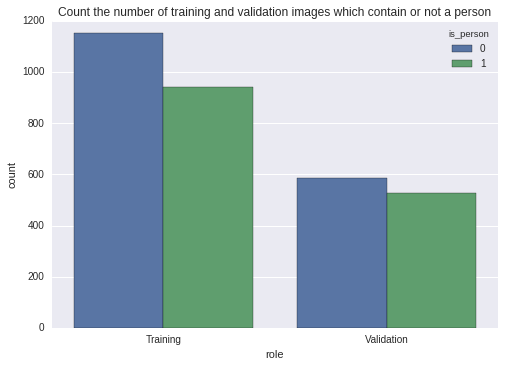

In [20]:
# Your code goes here
#ata = yTr.append(yVal)
#ssert len(data) == (len(yTr) + len(yVal))

sns.countplot(x="role", hue='is_person', data=targetsDataset)
sns.plt.title('Count the number of training and validation images which contain or not a person')

This case is not too bad because it shows that this is a balanced problem. An approximate equally number of pictures are characterized containing a person and not containg a person both in the validation and training dataset

### ========== Question 1.6 ==========
What would be a good choice for a baseline classifier to compare your results in the next steps against? What classification accuracy score does the baseline classifier achieve in the validation set?

*Your answer goes here*

The baseline classifier is a dummy classifier which is based on the prior probability. We always guess the most probable class and gain a classification accuracy this way

In [21]:
# Your code goes here
countIsPerson = len(yTr[yTr==True])
countIsNotPerson = len(yTr) - countIsPerson

print "the classification accuracy of the baseline classifier for training data is"
max(countIsPerson, countIsNotPerson) / len(yTr)

the classification accuracy of the baseline classifier for training data is


0.5508838987099857

In [22]:
# Your code goes here
countIsPerson = len(yVal[yVal==True])
countIsNotPerson = len(yVal) - countIsPerson

print "the classification accuracy of the baseline classifier for validation data is"
max(countIsPerson, countIsNotPerson) / len(yVal)

the classification accuracy of the baseline classifier for validation data is


0.5265049415992812

### ========== Question 1.7 ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier by using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score in the training and validation sets and compare to that of the baseline classifier. Comment in 1-2 sentences the results. You may include any additional plot(s) if you wish to justify your explanation.

In [23]:
# Your code goes here
logisticRegressionClassifier = LogisticRegression(solver='lbfgs')

In [24]:
logisticRegressionClassifier.fit(Xtr, yTr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
print "score of logistic regression classifier on training data"
print logisticRegressionClassifier.score(Xtr, yTr)
print
print "score of logistic regression classifier on validation data"
print logisticRegressionClassifier.score(Xval, yVal)

score of logistic regression classifier on training data
0.55088389871

score of logistic regression classifier on validation data
0.526504941599


In [26]:
print np.all(logisticRegressionClassifier.predict(Xval) == 0)
np.all(logisticRegressionClassifier.predict(Xtr) == 0)

True


True

*Your answer goes here*

Logistic regression seems to fail completely since from the previous cell we see that it calculates all values as zero, meaning non person, which is the most probable class, which is why the score is as low as the dummy classifier

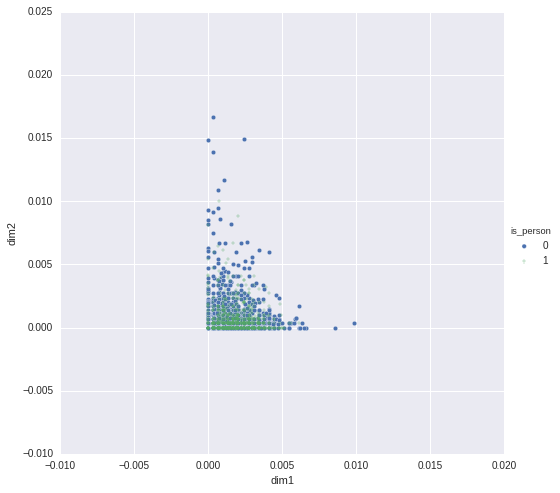

In [27]:
sns.pairplot(
    trainA,
    x_vars=[Xtr.columns[0]],
    y_vars=[Xtr.columns[1]],
    size=7, hue=targetName, markers=['o','+']
)

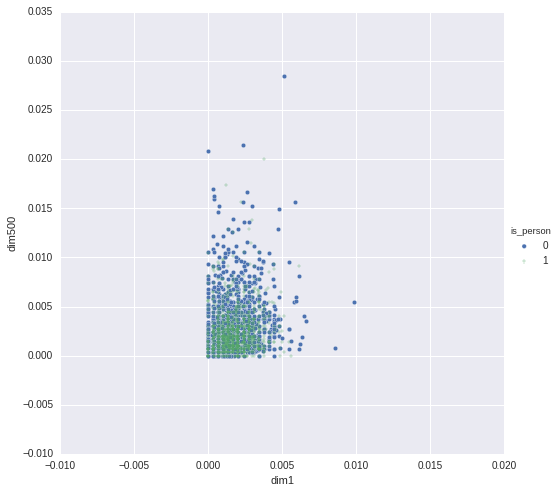

In [28]:
sns.pairplot(
    trainA,
    x_vars=[Xtr.columns[0]],
    y_vars=[Xtr.columns[-1]],
    size=7, hue=targetName, markers=['o','+']
)

*Your answer goes here*

By plotting two plots of feature0 vs feature1 and feature0 vs last feature we end up to a first hint that without preprocessing the data are falling on top of each other and we will not be able to distinguish them by a line which is the decision boundary of logistic regression.

In [29]:
cls1D = LogisticRegression(solver='lbfgs')
firstFeature = Xtr[Xtr.columns[0]].values[np.newaxis].T
cls1D.fit(firstFeature, yTr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
print cls1D.coef_
print cls1D.intercept_

[[ 0.10389246]]
[-0.20442546]


In [31]:
xspace = np.arange(-0.01, 0.01, 0.001)
xspace.shape

(20,)

In [32]:
def getSigmoid(xspace):
    return 1 / (1 + np.exp(cls1D.coef_[0][0] * xspace + cls1D.intercept_[0]))

getSigmoid(xspace).shape

(20,)

In [33]:
firstFeatureNoPerson = trainA[trainA[targetName] == 0][Xtr.columns[0]] #firstFeature[yTr==0] #this is not working :(
firstFeatureIsPerson = trainA[trainA[targetName] == 1][Xtr.columns[0]]

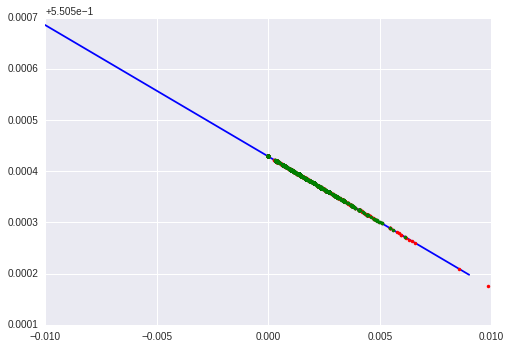

In [34]:
fig = plt.figure()
plt.hold(True)
plt.plot(xspace, getSigmoid(xspace), 'b-')
plt.plot(firstFeatureNoPerson, getSigmoid(firstFeatureNoPerson), 'r.')
plt.plot(firstFeatureIsPerson, getSigmoid(firstFeatureIsPerson), 'g.')
plt.hold(False)
plt.show()

*Your answer goes here*

To get more intuition of what is going on we are plotting the sigmoid that we have after fitting, this is the blue line, against what the values are for the first feature of the training data.

We are also plotting with red and green dots the "is person" and the "is not person" classes correspondigly and where their inputs fall on the sigmoid.

We see that all fall on the positive side therefore it makes sense that this fitting has failed as all inputs are going to be predicted as on the lower side of the sigmoid which is the zero.

### ========== Question 1.8 ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [35]:
# Your code goes here
np.set_printoptions(precision=3)

firstFiveFeatures = Xtr[Xtr.columns[:5]]
firstFiveFeatures.shape

(2093, 5)

In [36]:
print "the mean values of the first five features"
print np.mean(firstFiveFeatures, axis=0) #axis = 0 is per column for numpy
print
print "the standard deviations of the first five features"
np.std(firstFiveFeatures, axis = 0 ) #axis = 0 is per column for numpy

the mean values of the first five features
dim1    0.001751
dim2    0.000756
dim3    0.004317
dim4    0.001853
dim5    0.002272
dtype: float64

the standard deviations of the first five features


dim1    0.001193
dim2    0.001406
dim3    0.003693
dim4    0.001340
dim5    0.001598
dtype: float64

### ========== Question 1.9 ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers an [implementation](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) of feature standardisation. Create a standardiser and fit it by using training features only. Then transform both your input and validation input features. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. 

**IMPORTANT: You should use the transformed data for the rest of part A**.

In [37]:
# Your code goes here
standardScaler = StandardScaler()

In [38]:
standardScaler.fit(Xtr)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
Xtrain = standardScaler.transform(Xtr)
Xtrain.shape

(2093, 500)

In [40]:
# we fit on training data and we apply the SAME transformation on the validation data
# because whatever you do on the training data you have to do exactly the same on the testing or validation data

Xvalid = standardScaler.transform(Xval)
Xvalid.shape

(1113, 500)

In [41]:
def getMeansAndStds(array, noOfFirstAttrs):
    #firstFeatures = dataset[dataset.columns[:noOfFirstAttrs]]
    firstFeatures = array[:, :noOfFirstAttrs]
    assert firstFeatures.shape[0] > firstFeatures.shape[1], "in general we expect more lines than columns"
    assert firstFeatures.shape[1] == noOfFirstAttrs, "just to be sure that the transformation was ok"
    
    print "the mean values of the %d first features" % noOfFirstAttrs
    print np.mean(firstFeatures, axis=0) #axis = 0 is per column for numpy
    print
    print "the standard deviations of the %d first features" % noOfFirstAttrs
    print np.std(firstFeatures, axis = 0 ) #axis = 0 is per column for numpy

In [42]:
getMeansAndStds(Xtrain, 5)

the mean values of the 5 first features
[ -3.395e-17  -2.207e-17   2.444e-16   1.426e-16  -5.771e-17]

the standard deviations of the 5 first features
[ 1.  1.  1.  1.  1.]


*Your answer goes here*

Yes the standard scaler brings the mean to zero and the standard deviation to one.

As we see the standard deviations for all first five features are exactly equal to one and the means are zero (with rounding errors)

In [43]:
getMeansAndStds(Xvalid, 5)

the mean values of the 5 first features
[-0.006 -0.038  0.109  0.094  0.031]

the standard deviations of the 5 first features
[ 1.013  0.97   1.049  1.057  0.975]


*Your answer goes here*

Since the standarization has happened by subtracting the mean and dividing by the standard deviation, we are going to follow the exact same transformation on the validation data.

Unless we are very lucky and the validation data represent the distribution of our data as good as the training data then here the mean will not be exactly zero and the standard deviation will not be exactly 1.

However hopefully we want the mean and std of the validation data to be close to zero and one respectively. Otherwise it would mean that the validation belong to some other very different distribution and our predictions will be poor.

### ========== Question 1.10 ==========
By using the transformed input data, retrain a `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy in both the training and validation sets. How does your model compare to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [44]:
# Your code goes here
logisticRegressionClassifier = LogisticRegression(solver='lbfgs')
logisticRegressionClassifier.fit(Xtrain, yTr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
print "classification accuracy for training after standarization:"
print logisticRegressionClassifier.score(Xtrain, yTr)

classification accuracy for training after standarization:
0.810797897754


In [46]:
print "classification accuracy for validation after standarization:"
print logisticRegressionClassifier.score(Xvalid, yVal)

classification accuracy for validation after standarization:
0.643306379155


*Your answer goes here*

As we see here the classification accuracy is not as bad as before. High enough for training data and good but not very good for unseen validation data.

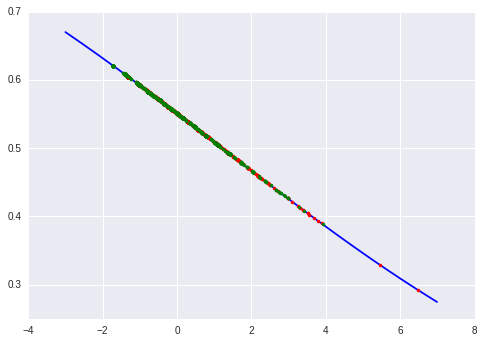

In [47]:
#Let's plot the same graph as in the original case to see how this difference looks like, even for one dimension

cls1D = LogisticRegression(solver='lbfgs')
firstFeature = Xtrain[:, :1]
cls1D.fit(firstFeature, yTr)

xspace = np.arange(-3, 7, 0.01)

def getSigmoid(x):
    return 1 / (1 + np.exp(cls1D.coef_[0][0] * x + cls1D.intercept_[0]))

firstFeatureNoPerson = trainA[trainA[targetName] == 0][Xtr.columns[0]].values[np.newaxis].T
firstFeatureNoPerson = StandardScaler().fit_transform(firstFeatureNoPerson)

firstFeatureIsPerson = trainA[trainA[targetName] == 1][Xtr.columns[0]].values[np.newaxis].T 
firstFeatureIsPerson = StandardScaler().fit_transform(firstFeatureIsPerson)

fig = plt.figure()
plt.hold(True)
plt.plot(xspace, getSigmoid(xspace), 'b-')
plt.plot(firstFeatureNoPerson, getSigmoid(firstFeatureNoPerson), 'r.')
plt.plot(firstFeatureIsPerson, getSigmoid(firstFeatureIsPerson), 'g.')
plt.hold(False)
plt.show()

*Your answer goes here*

We see from the new plot that now the data range from -2 to +7 and there are values which are larger than 0.5 which makes the classifier not classifying every data as if it belongs in the same class.

A simple standarization makes it work better

### ========== Question 1.11 ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes for the weight vector. Thus, it helps us prevent overfitting and, for logistic regression, it additionally controls the level of confidence in making predictions.

We would like to optimise this parameter **by using the transformed training dataset only** and not the validation set. Create a 3-fold cross-validation object for the training dataset. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples in each iteration fold.

In [48]:
# Your code goes here
k = 3
kFold = KFold(len(Xtrain), n_folds=k, shuffle=True, random_state=seed)

In [49]:
print "total number of training data:"
print len(Xtrain)
print
print "total num of training data divided by three"
print len(Xtrain)/3.

total number of training data:
2093

total num of training data divided by three
697.666666667


In [50]:
count = 1
for foldTurn in kFold:
    print "pass %d of %d-fold the count of training data is: " % (count, k)
    print foldTurn[0].shape
    print "pass %d of %d-fold the count of testing data is: " % (count, k)
    print foldTurn[1].shape
    print
    count += 1

pass 1 of 3-fold the count of training data is: 
(1395,)
pass 1 of 3-fold the count of testing data is: 
(698,)

pass 2 of 3-fold the count of training data is: 
(1395,)
pass 2 of 3-fold the count of testing data is: 
(698,)

pass 3 of 3-fold the count of training data is: 
(1396,)
pass 3 of 3-fold the count of testing data is: 
(697,)



### ========== Question 1.12 ========== 
Now we want to test out different settings for the regularisation parameter `C` by using the cross-validation iterator from the previous question. For each iteration, we want to train multiple classifiers by using a range of values for `C` and then compute the performance within each CV fold. You should use a log-range for `C` from `1e-5` to `1e5` by using 20 equally-spaced values *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters.

*(hint: your may want to use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [51]:
np.set_printoptions(precision=None)

# Your code goes here
CsLen = 20
Cs = np.logspace(start = -5, stop=5, num=CsLen)
assert len(Cs) == CsLen
print Cs.shape
Cs

(20,)


array([  1.000e-05,   3.360e-05,   1.129e-04,   3.793e-04,   1.274e-03,
         4.281e-03,   1.438e-02,   4.833e-02,   1.624e-01,   5.456e-01,
         1.833e+00,   6.158e+00,   2.069e+01,   6.952e+01,   2.336e+02,
         7.848e+02,   2.637e+03,   8.859e+03,   2.976e+04,   1.000e+05])

In [52]:
scoreArray = np.zeros((k, CsLen))
scoreArray.shape

(3, 20)

In [53]:
def onEachKFold(kFoldIterator, inputs, targets, action):
    i = 0
    for foldTurn in kFoldIterator:
        curTrainIndices, curTestingIndices = foldTurn

        curXtrain = Xtrain[curTrainIndices]
        curYtrain = yTr[curTrainIndices]

        curXvalid = Xtrain[curTestingIndices]
        curYvalid = yTr[curTestingIndices]    
        
        action(curXtrain, curYtrain, curXvalid, curYvalid, i)
        
        i += 1

In [54]:
def scoreEachC(trainingData, trainingTargets, testingData, testingTargets, i):
    j = 0
    for C in Cs:
        curClassifier = LogisticRegression(solver='lbfgs', C=C)
        curClassifier.fit(trainingData, trainingTargets)
        
        scoreArray[i, j] = curClassifier.score(testingData, testingTargets)
        
        j += 1

In [55]:
onEachKFold(kFoldIterator=kFold, inputs=Xtrain, targets = yTr, action=scoreEachC)

In [56]:
scoreArray

array([[ 0.573,  0.629,  0.668,  0.672,  0.688,  0.696,  0.675,  0.67 ,
         0.653,  0.659,  0.659,  0.653,  0.649,  0.646,  0.646,  0.649,
         0.646,  0.646,  0.649,  0.649],
       [ 0.546,  0.632,  0.695,  0.719,  0.729,  0.735,  0.702,  0.675,
         0.655,  0.636,  0.632,  0.633,  0.626,  0.628,  0.628,  0.626,
         0.626,  0.626,  0.628,  0.626],
       [ 0.548,  0.636,  0.643,  0.656,  0.68 ,  0.7  ,  0.681,  0.67 ,
         0.663,  0.644,  0.633,  0.626,  0.624,  0.624,  0.624,  0.624,
         0.624,  0.624,  0.624,  0.624]])

### ========== Question 1.13 ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

In [57]:
# Your code goes here
scoreMeans = np.mean(scoreArray, axis=0)
scoreMeans.shape

(20,)

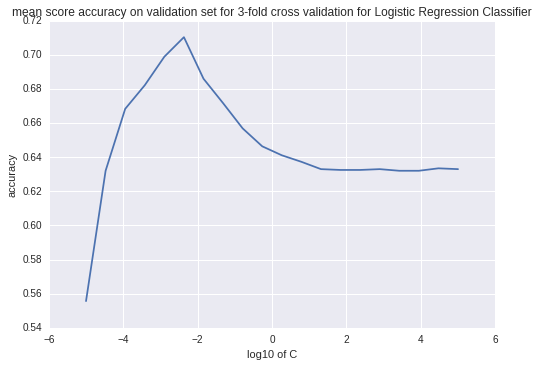

In [58]:
fig = plt.figure()
plt.plot(np.log10(Cs), scoreMeans)
plt.title('mean score accuracy on validation set for 3-fold cross validation for Logistic Regression Classifier',
         fontsize=12)
plt.ylabel('accuracy')
plt.xlabel('log10 of C')
plt.show()

### ========== Question 1.14 ==========
Find and display the optimal value for the regularisation parameter `C` of the logistic classifier by using your results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [59]:
# Your code goes here
optimalC = Cs[np.argmax(scoreMeans)]

print "optimal value for the regularization parameter C is"
print optimalC

optimal value for the regularization parameter C is
0.00428133239872


In [60]:
optimalClassifier = LogisticRegression(solver='lbfgs', C = optimalC)
optimalClassifier.fit(Xtrain, yTr)

LogisticRegression(C=0.0042813323987193914, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [61]:
print "the score of the validation set with the optimal classifier is"
optimalClassifier.score(Xvalid, yVal)

the score of the validation set with the optimal classifier is


0.69631626235399824

*Your answer goes here*

We notice that by using the optimal C value for the Logistic Regression Classifier the score accuracy has improved by a factor of

In [62]:
LogisticRegression(solver='lbfgs', C = optimalC).fit(Xtrain,yTr).score(Xvalid, yVal) / LogisticRegression(solver='lbfgs').fit(Xtrain,yTr).score(Xvalid, yVal)

1.0824022346368716

### ========== Question 1.15 ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Can you verify that your results are consistent with those from Question 1.14?

In [78]:
k

3

In [79]:
Cs

array([  1.000e-05,   3.360e-05,   1.129e-04,   3.793e-04,   1.274e-03,
         4.281e-03,   1.438e-02,   4.833e-02,   1.624e-01,   5.456e-01,
         1.833e+00,   6.158e+00,   2.069e+01,   6.952e+01,   2.336e+02,
         7.848e+02,   2.637e+03,   8.859e+03,   2.976e+04,   1.000e+05])

In [80]:
# Your code goes here
logisticRegressionCVclassifier = LogisticRegressionCV(solver='lbfgs', cv=k, Cs=Cs)

In [81]:
logisticRegressionCVclassifier.fit(Xtrain, yTr)

LogisticRegressionCV(Cs=array([  1.00000e-05,   3.35982e-05,   1.12884e-04,   3.79269e-04,
         1.27427e-03,   4.28133e-03,   1.43845e-02,   4.83293e-02,
         1.62378e-01,   5.45559e-01,   1.83298e+00,   6.15848e+00,
         2.06914e+01,   6.95193e+01,   2.33572e+02,   7.84760e+02,
         2.63665e+03,   8.85867e+03,   2.97635e+04,   1.00000e+05]),
           class_weight=None, cv=3, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=100, multi_class='ovr',
           n_jobs=1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [82]:
logisticRegressionCVclassifier.score(Xvalid, yVal)

0.69631626235399824

In [84]:
assert optimalClassifier.score(Xvalid, yVal) == logisticRegressionCVclassifier.score(Xvalid, yVal)

If assert passed successfully then this means that our "manual" process above gives the same results as the Logistic Regression CV

### ========== Question 1.16 ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 31 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [121]:
# Your code goes here
randomForestClassifier = RandomForestClassifier(
    n_estimators=500,
    random_state=31,
    criterion='entropy'
)

In [122]:
randomForestClassifier.fit(Xtrain, yTr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=31,
            verbose=0, warm_start=False)

In [131]:
print "training classification accuracy for the random forest classifier of full depth"
randomForestClassifier.score(Xtrain, yTr)

training classification accuracy for the random forest classifier of full depth


1.0

In [132]:
print "testing classification accuracy for the random forest classifier of full depth"
randomForestClassifier.score(Xvalid, yVal)

testing classification accuracy for the random forest classifier of full depth


0.69811320754716977

We notice that the random forest classifier has a little bit better classification accuracy at 70%

In [124]:
def getFeatureImportances(decisionTree, columnNames):
    featureImportances = dict()

    arrayFeatureImportances = decisionTree.feature_importances_

    counter = 0
    for col in columnNames:
        featureImportances[col] = arrayFeatureImportances[counter]
        counter += 1

    return featureImportances

In [125]:
featureImportances = getFeatureImportances(randomForestClassifier, inputFeatures)

In [126]:
print "most important features to least important features list:"
sorted(featureImportances, reverse = True, key=featureImportances.get)

most important features to least important features list:


['dim21',
 'dim479',
 'dim51',
 'dim360',
 'dim283',
 'dim76',
 'dim4',
 'dim461',
 'dim274',
 'dim330',
 'dim263',
 'dim343',
 'dim348',
 'dim217',
 'dim222',
 'dim347',
 'dim74',
 'dim356',
 'dim398',
 'dim423',
 'dim500',
 'dim73',
 'dim485',
 'dim214',
 'dim326',
 'dim254',
 'dim483',
 'dim92',
 'dim25',
 'dim322',
 'dim329',
 'dim427',
 'dim17',
 'dim288',
 'dim90',
 'dim440',
 'dim48',
 'dim206',
 'dim171',
 'dim154',
 'dim134',
 'dim54',
 'dim96',
 'dim315',
 'dim85',
 'dim312',
 'dim15',
 'dim35',
 'dim188',
 'dim442',
 'dim294',
 'dim289',
 'dim445',
 'dim160',
 'dim201',
 'dim153',
 'dim197',
 'dim358',
 'dim344',
 'dim257',
 'dim299',
 'dim77',
 'dim207',
 'dim114',
 'dim430',
 'dim353',
 'dim161',
 'dim402',
 'dim495',
 'dim142',
 'dim465',
 'dim420',
 'dim135',
 'dim498',
 'dim363',
 'dim118',
 'dim81',
 'dim71',
 'dim272',
 'dim375',
 'dim59',
 'dim79',
 'dim53',
 'dim271',
 'dim219',
 'dim357',
 'dim277',
 'dim444',
 'dim99',
 'dim170',
 'dim282',
 'dim27',
 'dim52',
 'd

We will try and prune the try to see if we can get a better performance

In [128]:
def trainAndScoreRandomForestClassifier(trainingInputs, trainingTargets,
                                        testingInputs, testingTargets,
                                        maxDepth=None,
                                        maxFeatures = 'auto',
                                        randomSeed=None,
                                        returnClassifier = False,
                                        n_estimators=500):    
    classifier = RandomForestClassifier(n_estimators=n_estimators,
                                  criterion='entropy',
                                  random_state = randomSeed,
                                  max_depth = maxDepth,
                                  max_features = maxFeatures).fit(trainingInputs, trainingTargets)
        
    curScore = classifier.score(testingInputs, testingTargets)
        
    return (curScore, classifier) if returnClassifier else curScore

In [130]:
maxDepths = range(1, 30)

scores = []

for maxDepth in maxDepths:
    scores.append(
        trainAndScoreRandomForestClassifier(
            trainingInputs=Xtrain,
            trainingTargets=yTr,
            testingInputs=Xvalid,
            testingTargets=yVal,
            randomSeed = 31,
            maxDepth = maxDepth
        )
    )

scores

[0.62982929020664868,
 0.65678346810422283,
 0.66936208445642409,
 0.67205750224618144,
 0.67834681042228206,
 0.68194070080862534,
 0.67834681042228206,
 0.6801437556154537,
 0.69182389937106914,
 0.69991015274034141,
 0.69002695417789761,
 0.69901168014375559,
 0.70440251572327039,
 0.70080862533692723,
 0.69811320754716977,
 0.69631626235399824,
 0.69811320754716977,
 0.69182389937106914,
 0.69631626235399824,
 0.69811320754716977,
 0.69541778975741242,
 0.69721473495058406,
 0.69721473495058406,
 0.69811320754716977,
 0.69811320754716977,
 0.69811320754716977,
 0.69811320754716977,
 0.69811320754716977,
 0.69811320754716977]

In [134]:
len(scores)

29

In [135]:
bestDepth = np.argmax(scores) + 1 #+1 because we used the pruning of the tree at depths 1, 2, 3, .. 29

bestDepth

13

In [136]:
bestScore, bestRandomForestClassifier = trainAndScoreRandomForestClassifier(
            trainingInputs=Xtrain,
            trainingTargets=yTr,
            testingInputs=Xvalid,
            testingTargets=yVal,
            randomSeed = 31,
            maxDepth = bestDepth,
            returnClassifier = True
        )

In [138]:
print "training classification accuracy of best random forest classifier"
print bestRandomForestClassifier.score(Xtrain, yTr)
print
print "testing classification accuracy of best random forest classifier"
bestScore

training classification accuracy of best random forest classifier
1.0

testing classification accuracy of best random forest classifier


0.70440251572327039

### ========== Question 1.17 ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

*Your answer goes here*

The way the structure of the random forest tree is created, by the data themselves, the expectation is to always have a path that belongs to a training instance with a full depth tree. Therefore we expect to always have perfect training accuracy of 100% of a random forest tree no matter how peculiar is our distribution.

Of course on unseen data the performance of a full random forest tree is not spectacular at all. Actually it is the same as the logistic regression classifier with optimal C.

Using a range of various depths to try and find a better random forest classifier we see that even with the best pruning we are not able to improve accuracy of more than 1%

### ========== Question 1.18 ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [139]:
featureImportances = getFeatureImportances(bestRandomForestClassifier, inputFeatures)
sortedFeatureImportances = sorted(featureImportances, reverse = True, key=featureImportances.get)

In [140]:
# Your code goes here
print "50 most important features to least important features list:"
sortedFeatureImportances[:50]

50 most important features to least important features list:


['dim21',
 'dim51',
 'dim360',
 'dim283',
 'dim479',
 'dim76',
 'dim4',
 'dim222',
 'dim461',
 'dim330',
 'dim217',
 'dim343',
 'dim423',
 'dim274',
 'dim347',
 'dim263',
 'dim356',
 'dim326',
 'dim348',
 'dim398',
 'dim214',
 'dim485',
 'dim254',
 'dim74',
 'dim206',
 'dim483',
 'dim427',
 'dim73',
 'dim92',
 'dim322',
 'dim25',
 'dim17',
 'dim90',
 'dim134',
 'dim85',
 'dim54',
 'dim171',
 'dim96',
 'dim440',
 'dim500',
 'dim153',
 'dim35',
 'dim154',
 'dim329',
 'dim48',
 'dim289',
 'dim77',
 'dim315',
 'dim312',
 'dim188']

### ========== Question 1.19 ==========
Next, we would like to test out the performance of support vector classification and experiment with different kernels. 
By using training data only and default parameter settings, train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [142]:
# Your code goes here
linearSVC = LinearSVC()

In [143]:
linearSVC.fit(Xtrain, yTr)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [144]:
print "training classification accuracy of linear support vector classifier"
linearSVC.score(Xtrain, yTr)

training classification accuracy of linear support vector classifier


0.79503105590062106

In [145]:
print "testing classification accuracy of linear support vector classifier"
linearSVC.score(Xvalid, yVal)

testing classification accuracy of linear support vector classifier


0.64869721473495057

The classification accuracy of the Linear Support Vector Classifier is not something awesome in comparison to previous classifiers. We need to explore how could we transform the data with radial basis function or a polynomial

In [146]:
rbfSVC = SVC(kernel='rbf')

In [147]:
rbfSVC.fit(Xtrain, yTr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [148]:
print "training classification accuracy for support vector classifier with RBF kernel"
rbfSVC.score(Xtrain, yTr)

training classification accuracy for support vector classifier with RBF kernel


0.9106545628284759

In [149]:
print "testing classification accuracy for support vector classifier with RBF kernel"
rbfSVC.score(Xvalid, yVal)

testing classification accuracy for support vector classifier with RBF kernel


0.72955974842767291

The transformation of the data using RBF has improved the classification accuracy

In [151]:
def scorePolySVC(degree=2):
    polySVC = SVC(kernel='poly',degree=degree).fit(Xtrain, yTr)
    return polySVC.score(Xtrain, yTr), polySVC.score(Xvalid, yVal)

In [153]:
polyScores = dict()

for degree in range(2, 10):
    polyScores[degree] = scorePolySVC(degree=degree)

In [155]:
polyScores

{2: (0.93979933110367897, 0.68553459119496851),
 3: (0.99092212135690394, 0.70170709793351305),
 4: (0.998088867654085, 0.67744833782569636),
 5: (0.99426660296225511, 0.61275831087151844),
 6: (0.97276636407071193, 0.56244384546271342),
 7: (0.94266602962255142, 0.54627133872416889),
 8: (0.96082178690874342, 0.54267744833782572),
 9: (0.99378881987577639, 0.59478885893980238)}

In [160]:
polyValScores = [tupl[1] for tupl in polyScores.values()]
bestPolyDegree = polyScores.keys()[np.argmax(polyValScores)]
bestPolyDegree

3

In [161]:
bestPolySVC = SVC(kernel='poly',degree=bestPolyDegree).fit(Xtrain, yTr)

In [162]:
print "training classification accuracy of SVC with kernel poly with degree 3 is"
bestPolySVC.score(Xtrain, yTr)

training classification accuracy of SVC with kernel poly with degree 3 is


0.99092212135690394

In [164]:
print "testing classification accuracy of SVC with kernel poly with degree 3 is"
bestPolySVC.score(Xvalid, yVal)

testing classification accuracy of SVC with kernel poly with degree 3 is


0.70170709793351305

The best validation accuracy of the SVC with kernel poly with optimal degree could not match the classification accuracy of SVC with RBF kernel

### ========== Question 1.20 ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the results by using 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [67]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

In [68]:
# Your code goes here


*Your answer goes here*



### ========== Question 1.21 ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [69]:
# Your code goes here


### ========== Question 1.22 ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [70]:
# Your code goes here


### ========== Question 1.23 ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

In [71]:
# Your code goes here 


### ========== Question 1.24 ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

*Your answer goes here*



### ========== Question 1.25 ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [72]:
# Your code goes here


### ========== Question 1.26 ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

*Your answer goes here*



### ========== Question 1.27 ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [73]:
# Your code goes here


*Your answer goes here*



## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classiffier you like (with the provison that you can explain what the classiffier/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the posterior probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated posterior probabilities for the data points in the test set into a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. You are then required to copy this file into your submission folder along with your notebook (see Mecanics section at the top of the notebook) and then submit the two files by using the `submit` command on DICE. You are only required to use the `submit` command once.

*Your answer goes here (max. 600 words)*



In [74]:
# Your code goes here

In [75]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array has not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

save_predictions(pred_proba) # You need to replace "pred_proba" with the name of the array
                             # which contains the probability estimates for the data in 
                             # the test set.

NameError: name 'pred_proba' is not defined

*Your answer goes here*

